#**Творческое задание Блок №2**

#**Задание 1**

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import skew

In [ ]:
data = pd.read_excel('/content/Общая таблица_дз2_макро.xlsx')

Все наши данные, кроме темпа прироста реального ВВП, являются аннуализированными. Поэтому нам нужно  преобразовать квартальные темпы роста в аннуализированные значения. Для этого будем использовать формулу:

$$
\text{Аннуализированный темп роста ВВП} = \left(1 + \text{Квартальный темп роста ВВП}\right) {^  4} - 1
$$



In [ ]:
data['ANNUALIZED_GDP'] = ((1 + data['GDP'] / 100) ** 4 - 1) * 100

Теперь найдем разрыв выпуска (реального ВВП). Для этого будем воспользуемся фильтром Ходрика-Прескотта, реализованном в библиотеке statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html

Используем функцию `sm.tsa.filters.hpfilter()` для разделения данных о ВВП на две составляющие:  
- **Циклическая компонента**: краткосрочные отклонения.  
- **Трендовая компонента**: потенциальный ВВП (долгосрочный тренд).  

Стандартное значение параметра сглаживания:  
$
\lambda = 1600
$
(используется для квартальных данных).

Используемая формула:
$$
\min \sum_{t} (y_t - \hat{y}_t)^2 + \lambda \sum_{t} (\hat{y}_{t+1} - 2\hat{y}_t + \hat{y}_{t-1})^2
$$

где:  
- $y_t$ — фактический ВВП.  
- $\hat{y}_t$ — потенциальный ВВП.  
- $\lambda$ — параметр сглаживания ($\lambda = 1600 $) для квартальных данных.

In [ ]:
cycle, trend = sm.tsa.filters.hpfilter(data['ANNUALIZED_GDP'], lamb=1600)
data['OUTPUT_GAP'] = cycle

In [ ]:
data.head()

,YEAR,QUARTER,INFLATION,CORE_INFLATION,EXP_INFLATION,GDP,EMPLOYMENT_RATE,ANNUALIZED_GDP,OUTPUT_GAP
0,2000,Q1,0.8,0.13,2.2,1.2,72.3,4.887093,1.888960
1,2000,Q2,0.6,-0.03,2.4,0.7,72.5,2.829537,-0.121127
2,2000,Q3,0.8,0.00,2.2,0.6,72.6,2.421687,-0.482690
3,2000,Q4,1.0,0.23,2.3,0.6,72.5,2.421687,-0.438688
4,2001,Q1,0.9,0.46,2.1,0.9,72.6,3.648892,0.829431


Задание 10. Очистим изначальные временные ряды от сезонности

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def remove_seasonality(series, period=4):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    return series - decomposition.seasonal

data['INFLATION_deseasoned'] = remove_seasonality(data['INFLATION'])
data['CORE_INFLATION_deseasoned'] = remove_seasonality(data['CORE_INFLATION'])
data['EXP_INFLATION_deseasoned'] = remove_seasonality(data['EXP_INFLATION'])
data['GDP_deseasoned'] = remove_seasonality(data['GDP'])
data['EMPLOYMENT_RATE_deseasoned'] = remove_seasonality(data['EMPLOYMENT_RATE'])
data['ANNUALIZED_GDP_deseasoned'] = remove_seasonality(data['ANNUALIZED_GDP'])
data['OUTPUT_GAP_deseasoned'] = remove_seasonality(data['OUTPUT_GAP'])

Проверим все ряды на наличие единичного корня

Используем тест Дики-Фуллера. Если ряд не стационарен, то его нужно дифференцировать.

Если p-value больше 0.05, ряд не стационарен и необходимо выполнить дифференцирование.

In [ ]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1]
print("INFLATION p-value:", check_stationarity(data['INFLATION_deseasoned']))
print("CORE_INFLATION p-value:", check_stationarity(data['CORE_INFLATION_deseasoned']))
print("EXP_INFLATION p-value:", check_stationarity(data['EXP_INFLATION_deseasoned']))
print("GDP p-value:", check_stationarity(data['GDP_deseasoned']))
print("EMPLOYMENT_RATE p-value:", check_stationarity(data['EMPLOYMENT_RATE_deseasoned']))
print("ANNUALIZED_GDP p-value:", check_stationarity(data['ANNUALIZED_GDP_deseasoned']))
print("OUTPUT_GAP p-value:", check_stationarity(data['OUTPUT_GAP_deseasoned']))


INFLATION p-value: 0.4149112851184936
CORE_INFLATION p-value: 0.9163871933131384
EXP_INFLATION p-value: 0.05391653301430031
GDP p-value: 4.578256771489147e-16
EMPLOYMENT_RATE p-value: 0.5849897169778493
ANNUALIZED_GDP p-value: 6.00216817873551e-07
OUTPUT_GAP p-value: 3.169900765808339e-18


In [ ]:
data['INFLATION_diff'] = data['INFLATION_deseasoned'].diff()
data['CORE_INFLATION_diff'] = data['CORE_INFLATION_deseasoned'].diff()
data['EXP_INFLATION_diff'] = data['EXP_INFLATION_deseasoned'].diff()
data['GDP_diff'] = data['GDP_deseasoned'].diff()
data['EMPLOYMENT_RATE_diff'] = data['EMPLOYMENT_RATE_deseasoned'].diff()
data['ANNUALIZED_GDP_diff'] = data['ANNUALIZED_GDP_deseasoned'].diff()
data['OUTPUT_GAP_diff'] = data['OUTPUT_GAP_deseasoned'].diff()

In [ ]:
data = data.iloc[1:].reset_index(drop=True)

#**Задание 2**

In [ ]:
col = data[['INFLATION_diff', 'CORE_INFLATION_diff', 'EXP_INFLATION_diff', 'ANNUALIZED_GDP_diff', 'EMPLOYMENT_RATE_diff', 'OUTPUT_GAP_diff']]

stat_my_data = {
    'min': col.min(),
    'max': col.max(),
    'median': col.median(),
    'mode': col.mode().iloc[0],
    'mean': col.mean(),
    'std': col.std(),
    'skew': skew(col)
}

stat_df = pd.DataFrame(stat_my_data)

display(stat_df)

,min,max,median,mode,mean,std,skew
INFLATION_diff,-2.473958,2.956522,0.044531,0.032541,0.012133,0.739586,0.270176
CORE_INFLATION_diff,-1.065990,1.294010,-0.008919,-0.000392,0.032528,0.389724,0.513251
EXP_INFLATION_diff,-2.815000,1.373698,0.008785,-0.146128,0.007054,0.444443,-2.228480
ANNUALIZED_GDP_diff,-76.574097,140.674375,0.328928,-5.899351,-0.090223,18.068286,3.948781
EMPLOYMENT_RATE_diff,-0.909737,0.505208,0.065987,0.190263,0.026084,0.259981,-0.982664
OUTPUT_GAP_diff,-76.730048,140.454387,0.517606,-76.730048,-0.070893,18.062710,3.918894


#**Задание 3**

**Спецификация 1:**
$$
\pi_{t+4}^4 - \pi_t = \alpha + \beta_1 (\pi_t - \pi_{t-1}) + \beta_2 (\pi_{t-1} - \pi_{t-2}) + \beta_3 (\pi_{t-2} - \pi_{t-3}) + \beta_4 (\pi_{t-3} - \pi_{t-4}) + \epsilon_t
$$

Создадим таблицу для первой спецификации, в которой будем хранить разницу аннуализированной квартальной инфляции между двумя соседними кварталами.

In [ ]:
spec1 = pd.DataFrame()

spec1['t_t-1'] = data['INFLATION_diff'] - data['INFLATION_diff'].shift(1)
spec1['t-1_t-2'] = data['INFLATION_diff'].shift(1) - data['INFLATION_diff'].shift(2)
spec1['t-2_t-3'] = data['INFLATION_diff'].shift(2) - data['INFLATION_diff'].shift(3)
spec1['t-3_t-4'] = data['INFLATION_diff'].shift(3) - data['INFLATION_diff'].shift(4)

spec1['t_4_t'] = data['INFLATION_diff'].shift(-4) - data['INFLATION_diff']

spec1.head()

,t_t-1,t-1_t-2,t-2_t-3,t-3_t-4,t_4_t
0,NaN,NaN,NaN,NaN,0.8
1,0.476019,NaN,NaN,NaN,-0.2
2,-0.006499,0.476019,NaN,NaN,-0.7
3,-0.341146,-0.006499,0.476019,NaN,0.6
4,0.671626,-0.341146,-0.006499,0.476019,-1.2


In [ ]:
spec1 = spec1.dropna() # есть пропуски, их необходимо удалить перед обучением модели

Перейдем к построению МНК оценок для Спецификации 1:

In [ ]:
X = spec1.drop(columns=['t_4_t'])
y = spec1['t_4_t']

X = sm.add_constant(X)

model = sm.OLS(y, X)
result1 = model.fit()
y_pred = result1.predict(X)
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                  t_4_t   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     4.993
Date:                Mon, 25 Nov 2024   Prob (F-statistic):            0.00116
Time:                        17:09:46   Log-Likelihood:                -127.50
No. Observations:                  90   AIC:                             265.0
Df Residuals:                      85   BIC:                             277.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0822      0.108     -0.759      0.4

In [ ]:
mse1 = result1.mse_resid
rmse1 = np.sqrt(mse1)
rmse1

1.0266255636489545

**Спецификация 2:**

$$
\pi_{t+4}^4 = \pi_t - \pi_{t-4} + \epsilon_t
$$

In [ ]:
spec2 = pd.DataFrame()

spec2['t_4'] = data['INFLATION_diff'].shift(-4) - data['INFLATION_diff']
spec2['t_t-4'] = data['INFLATION_diff'] - data['INFLATION_diff'].shift(4)

spec2 = spec2.dropna()

spec2.head()

,t_4,t_t-4
4,-1.2,0.8
5,0.1,-0.2
6,1.0,-0.7
7,-0.5,0.6
8,0.4,-1.2


In [ ]:
X = spec2['t_4']
y = spec2['t_t-4']

X = sm.add_constant(X)

model = sm.OLS(y, X)
result2 = model.fit()
y_pred2 = result2.predict(X)

In [ ]:
mse2 = result2.mse_resid
rmse2 = np.sqrt(mse2)
rmse2

0.9848215937626438

Теперь составим сводную таблицу по RMSE по годам. Для этого разделим данные (с 2000 по 3 квартал 2024 на четыре периода по шесть лет):

2000–2005 - первый период

2006–2011 - второй период

2012–2017 - третий период

2018–2024 - четвертый период

Для каждого из этих периодов аналогичным образом построим регрессии и найдем RMSE.


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

data['PERIOD'] = ((data['YEAR'] - data['YEAR'].min()) // 6) + 1
periods = ['2000:Q1 – 2005:Q4', '2006:Q1 – 2011:Q4', '2012:Q1 – 2017:Q4', '2018:Q1 – 2024:Q3']

def run_regressions_limited(data):
    results = []
    periods_map = {i + 1: periods[i] for i in range(len(periods))}
    for period in range(1, 5):  # Оставляем только первые 4 периода
        period_data = data[data['PERIOD'] == period]

        spec1_period = pd.DataFrame()
        spec1_period['t_t-1'] = period_data['INFLATION_diff'] - period_data['INFLATION_diff'].shift(1)
        spec1_period['t-1_t-2'] = period_data['INFLATION_diff'].shift(1) - period_data['INFLATION_diff'].shift(2)
        spec1_period['t-2_t-3'] = period_data['INFLATION_diff'].shift(2) - period_data['INFLATION_diff'].shift(3)
        spec1_period['t-3_t-4'] = period_data['INFLATION_diff'].shift(3) - period_data['INFLATION_diff'].shift(4)
        spec1_period['t_4_t'] = period_data['INFLATION_diff'].shift(-4) - period_data['INFLATION_diff']
        spec1_period = spec1_period.dropna()

        if not spec1_period.empty:
            X1 = spec1_period.drop(columns=['t_4_t'])
            y1 = spec1_period['t_4_t']
            X1 = sm.add_constant(X1)
            model1 = sm.OLS(y1, X1).fit()
            mse1 = model1.mse_resid
            rmse1 = np.sqrt(mse1)
        else:
            rmse1 = None

        spec2_period = pd.DataFrame()
        spec2_period['t_4'] = period_data['INFLATION_diff'].shift(-4) - period_data['INFLATION_diff']
        spec2_period['t_t-4'] = period_data['INFLATION_diff'] - period_data['INFLATION_diff'].shift(4)
        spec2_period = spec2_period.dropna()

        if not spec2_period.empty:
            X2 = spec2_period['t_4']
            y2 = spec2_period['t_t-4']
            X2 = sm.add_constant(X2)
            model2 = sm.OLS(y2, X2).fit()
            mse2 = model2.mse_resid
            rmse2 = np.sqrt(mse2)
        else:
            rmse2 = None

        results.append({
            'Period': periods_map.get(period, f"Period {period}"),
            'Regression with CPI inflation': rmse1,
            'Naive forecast with CPI inflation': rmse2
        })

    return pd.DataFrame(results)

regression_results_limited = run_regressions_limited(data)

print(regression_results_limited)

              Period  Regression with CPI inflation  \
0  2000:Q1 – 2005:Q4                       0.337789   
1  2006:Q1 – 2011:Q4                       0.834695   
2  2012:Q1 – 2017:Q4                       0.478124   
3  2018:Q1 – 2024:Q3                       1.896928   

   Naive forecast with CPI inflation  
0                           0.424847  
1                           1.002409  
2                           0.563530  
3                           1.103247  


In [ ]:
regression_results_limited

,Period,Regression with CPI inflation,Naive forecast with CPI inflation
0,2000:Q1 – 2005:Q4,0.337789,0.424847
1,2006:Q1 – 2011:Q4,0.834695,1.002409
2,2012:Q1 – 2017:Q4,0.478124,0.563530
3,2018:Q1 – 2024:Q3,1.896928,1.103247


In [ ]:
table1 = {
    "Method": ["Regression with CPI inflation", "Naive forecast with CPI inflation"],
    "RMSE": [1.0286488587432456, 0.9893573904053092]
}
table1 = pd.DataFrame(table1)


In [ ]:
table1

,Method,RMSE
0,Regression with CPI inflation,1.028649
1,Naive forecast with CPI inflation,0.989357


#**Задание 4**

**Спецификация 1 (базовая инфляция)**:

In [ ]:
spec1_core = pd.DataFrame()

spec1_core['t_t-1'] = data['CORE_INFLATION_diff'] - data['CORE_INFLATION_diff'].shift(1)
spec1_core['t-1_t-2'] = data['CORE_INFLATION_diff'].shift(1) - data['CORE_INFLATION_diff'].shift(2)
spec1_core['t-2_t-3'] = data['CORE_INFLATION_diff'].shift(2) - data['CORE_INFLATION_diff'].shift(3)
spec1_core['t-3_t-4'] = data['CORE_INFLATION_diff'].shift(3) - data['CORE_INFLATION_diff'].shift(4)

spec1_core['t_4_t'] = data['CORE_INFLATION_diff'].shift(-4) - data['CORE_INFLATION_diff']

In [ ]:
spec1_core = spec1_core.dropna()

In [ ]:
X = spec1_core.drop(columns=['t_4_t'])
y = spec1_core['t_4_t']

X = sm.add_constant(X)

model = sm.OLS(y, X)
result1_core = model.fit()
y_pred3 = result1_core.predict(X)

In [ ]:
mse1_core = result1_core.mse_resid
rmse1_core = np.sqrt(mse1_core)
rmse1_core

0.49234959424601576

**Спецификация 2 (базовая инфляция)**:

In [ ]:
spec2_core = pd.DataFrame()

spec2_core['t_4'] = data['CORE_INFLATION_diff'].shift(-4) - data['CORE_INFLATION_diff']
spec2_core['t_t-4'] = data['CORE_INFLATION_diff'] - data['CORE_INFLATION_diff'].shift(4)

spec2_core = spec2_core.dropna()

In [ ]:
X = spec2_core['t_4']
y = spec2_core['t_t-4']

X = sm.add_constant(X)

model = sm.OLS(y, X)
result2_core = model.fit()
y_pred4 = result2_core.predict(X)

In [ ]:
mse2_core = result2_core.mse_resid
rmse2_core = np.sqrt(mse2_core)
rmse2_core

0.4902529822543664

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def run_regressions_limited(data):
    results = []
    periods_map = {i + 1: periods[i] for i in range(len(periods))}
    for period in range(1, 5):
        period_data = data[data['PERIOD'] == period]

        spec1_period = pd.DataFrame()
        spec1_period['t_t-1'] = period_data['CORE_INFLATION_diff'] - period_data['CORE_INFLATION_diff'].shift(1)
        spec1_period['t-1_t-2'] = period_data['CORE_INFLATION_diff'].shift(1) - period_data['CORE_INFLATION_diff'].shift(2)
        spec1_period['t-2_t-3'] = period_data['CORE_INFLATION_diff'].shift(2) - period_data['CORE_INFLATION_diff'].shift(3)
        spec1_period['t-3_t-4'] = period_data['CORE_INFLATION_diff'].shift(3) - period_data['CORE_INFLATION_diff'].shift(4)
        spec1_period['t_4_t'] = period_data['CORE_INFLATION_diff'].shift(-4) - period_data['CORE_INFLATION_diff']
        spec1_period = spec1_period.dropna()

        if not spec1_period.empty:
            X1 = spec1_period.drop(columns=['t_4_t'])
            y1 = spec1_period['t_4_t']
            X1 = sm.add_constant(X1)
            model1 = sm.OLS(y1, X1).fit()
            mse1 = model1.mse_resid
            rmse1 = np.sqrt(mse1)
        else:
            rmse1 = None

        spec2_period = pd.DataFrame()
        spec2_period['t_4'] = period_data['CORE_INFLATION_diff'].shift(-4) - period_data['CORE_INFLATION_diff']
        spec2_period['t_t-4'] = period_data['CORE_INFLATION_diff'] - period_data['CORE_INFLATION_diff'].shift(4)
        spec2_period = spec2_period.dropna()

        if not spec2_period.empty:
            X2 = spec2_period['t_4']
            y2 = spec2_period['t_t-4']
            X2 = sm.add_constant(X2)
            model2 = sm.OLS(y2, X2).fit()
            mse2 = model2.mse_resid
            rmse2 = np.sqrt(mse2)
        else:
            rmse2 = None

        results.append({
            'Period': periods_map.get(period, f"Period {period}"),
            'Spec1_core_RMSE': rmse1,
            'Spec2_core_RMSE': rmse2
        })

    return pd.DataFrame(results)

regression_results_limited1 = run_regressions_limited(data)

print(regression_results_limited1.to_string(index=False))

           Period  Spec1_core_RMSE  Spec2_core_RMSE
2000:Q1 – 2005:Q4         0.304588         0.352728
2006:Q1 – 2011:Q4         0.319736         0.477538
2012:Q1 – 2017:Q4         0.209258         0.353971
2018:Q1 – 2024:Q3         0.880518         0.653391


In [ ]:
result = pd.merge(regression_results_limited, regression_results_limited1, on="Period")
result

,Period,Regression with CPI inflation,Naive forecast with CPI inflation,Spec1_core_RMSE,Spec2_core_RMSE
0,2000:Q1 – 2005:Q4,0.337789,0.424847,0.304588,0.352728
1,2006:Q1 – 2011:Q4,0.834695,1.002409,0.319736,0.477538
2,2012:Q1 – 2017:Q4,0.478124,0.563530,0.209258,0.353971
3,2018:Q1 – 2024:Q3,1.896928,1.103247,0.880518,0.653391


In [ ]:
table2 = {
    "Method": ["Spec1_core_RMSE", "Spec2_core_RMSE"],
    "RMSE": [0.4903142634301581, 0.48950158470020094]
}
table2 = pd.DataFrame(table2)
table2

,Method,RMSE
0,Spec1_core_RMSE,0.490314
1,Spec2_core_RMSE,0.489502


In [ ]:
result_rmse = pd.concat([table1, table2], ignore_index=True)
result_rmse

,Method,RMSE
0,Regression with CPI inflation,1.028649
1,Naive forecast with CPI inflation,0.989357
2,Spec1_core_RMSE,0.490314
3,Spec2_core_RMSE,0.489502


#**Задание 5**

**Спецификация 3:**

$$
\pi_{t+4}^4 = \alpha + \beta \pi_{t+4/t}^e
$$


In [ ]:
spec3 = pd.DataFrame()

spec3['t_4'] = data['INFLATION_diff'].shift(-4)
spec3['exp'] = data['EXP_INFLATION_diff']

spec3 = spec3.dropna()

Для начала рассчитаем оценку *Спецификации 3* для одного периода длительностью 24 года:

In [ ]:
y = spec3['t_4']
X = spec3['exp']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result3 = model.fit()
y_pred5 = result3.predict(X)
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    t_4   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3533
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.554
Time:                        17:09:47   Log-Likelihood:                -106.16
No. Observations:                  94   AIC:                             216.3
Df Residuals:                      92   BIC:                             221.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0139      0.078      0.177      0.860      -0.141       0.169
exp           -0.1045      0.176     -0.594      0.554      -0.454       0.245
==============================================================================
Omnibus:                       13.410   Durbin-Watson:                   0.896
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               39.316
Skew:                           0.272   Prob(JB):                     2.90e-09
Kurtosis:                       6.121   Cond. No.                         2.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mse3_core = result3.mse_resid
rmse3_core = np.sqrt(mse3_core)
print(f"RMSE: {rmse3_core:.4f}")

RMSE: 0.7567


Теперь рассчитаем оценку *Спецификации 3* для четырех сгруппированных периодов по 6 лет:

In [ ]:
def run_spec3(data):
    results = []
    for period in range(1, 5):
        period_data = data[data['PERIOD'] == period]

        spec3 = pd.DataFrame()
        spec3['t_4'] = period_data['INFLATION_diff'].shift(-4)
        spec3['exp'] = period_data['EXP_INFLATION_diff']
        spec3 = spec3.dropna()

        if not spec3.empty:
            y = spec3['t_4']
            X = spec3['exp']
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            mse3 = model.mse_resid
            rmse3 = np.sqrt(mse3)
        else:
            rmse3 = None

        results.append({
            'Period': periods[period - 1] if period <= len(periods) else f"Period {period}",
            'Spec3_RMSE': rmse3
        })

    return pd.DataFrame(results)

results_spec3 = run_spec3(data)
results_spec3.rename(columns={'Spec3_RMSE': 'Spec 3 RMSE'}, inplace=True)

print(results_spec3.to_string(index=False))

           Period  Spec 3 RMSE
2000:Q1 – 2005:Q4     0.323488
2006:Q1 – 2011:Q4     0.680130
2012:Q1 – 2017:Q4     0.414272
2018:Q1 – 2024:Q3     1.351289


**Спецификация 4:**

$$
\pi_{t+4}^4 = \alpha + \beta \left( \pi_t^e - \pi_{t-4}^e \right)
$$

In [ ]:
spec4 = pd.DataFrame()

spec4['t_4'] = data['INFLATION_diff'].shift(-4)
spec4['exp_t_t_4'] = data['EXP_INFLATION_diff'] - data['EXP_INFLATION_diff'].shift(4)

spec4 = spec4.dropna()

Для начала рассчитаем оценку *Спецификации 4* для одного периода длительностью 24 года:

In [ ]:
y = spec4['t_4']
X = spec4['exp_t_t_4']

X = sm.add_constant(X)
model = sm.OLS(y, X)
result4 = model.fit()
y_pred6 = result4.predict(X)
mse4_core = result4.mse_resid
rmse4_core = np.sqrt(mse4_core)
print(f"RMSE: {rmse4_core:.4f}")

RMSE: 0.7681


Теперь рассчитаем оценку *Спецификации 4* для четырех сгруппированных периодов по 6 лет:

In [ ]:
def run_spec4(data):
    results = []
    for period in range(1, 5):
        period_data = data[data['PERIOD'] == period]

        spec4 = pd.DataFrame()
        spec4['t_4'] = period_data['INFLATION_diff'].shift(-4)
        spec4['exp_t_t_4'] = period_data['EXP_INFLATION_diff'] - period_data['EXP_INFLATION_diff'].shift(4)
        spec4 = spec4.dropna()

        if not spec4.empty:
            y = spec4['t_4']
            X = spec4['exp_t_t_4']
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            mse4 = model.mse_resid
            rmse4 = np.sqrt(mse4)
        else:
            rmse4 = None

        results.append({
            'Period': periods[period - 1] if period <= len(periods) else f"Period {period}",
            'Spec4_RMSE': rmse4
        })

    return pd.DataFrame(results)

results_spec4 = run_spec4(data)
results_spec4.rename(columns={'Spec4_RMSE': 'Spec 4 RMSE'}, inplace=True)
print(results_spec4.to_string(index=False))

           Period  Spec 4 RMSE
2000:Q1 – 2005:Q4     0.302150
2006:Q1 – 2011:Q4     0.744408
2012:Q1 – 2017:Q4     0.412442
2018:Q1 – 2024:Q3     1.515112


In [ ]:
result = pd.merge(result, results_spec3, on="Period")
result

,Period,Regression with CPI inflation,Naive forecast with CPI inflation,Spec1_core_RMSE,Spec2_core_RMSE,Spec 3 RMSE
0,2000:Q1 – 2005:Q4,0.337789,0.424847,0.304588,0.352728,0.323488
1,2006:Q1 – 2011:Q4,0.834695,1.002409,0.319736,0.477538,0.680130
2,2012:Q1 – 2017:Q4,0.478124,0.563530,0.209258,0.353971,0.414272
3,2018:Q1 – 2024:Q3,1.896928,1.103247,0.880518,0.653391,1.351289


In [ ]:
result = pd.merge(result, results_spec4, on="Period")
result

,Period,Regression with CPI inflation,Naive forecast with CPI inflation,Spec1_core_RMSE,Spec2_core_RMSE,Spec 3 RMSE,Spec 4 RMSE
0,2000:Q1 – 2005:Q4,0.337789,0.424847,0.304588,0.352728,0.323488,0.302150
1,2006:Q1 – 2011:Q4,0.834695,1.002409,0.319736,0.477538,0.680130,0.744408
2,2012:Q1 – 2017:Q4,0.478124,0.563530,0.209258,0.353971,0.414272,0.412442
3,2018:Q1 – 2024:Q3,1.896928,1.103247,0.880518,0.653391,1.351289,1.515112


In [ ]:
table3 = {
    "Method": ["Spec 3 RMSE", "Spec 4 RMSE"],
    "RMSE": [0.7585, 0.7695]
}
table3 = pd.DataFrame(table3)
result_rmse = pd.concat([result_rmse, table3], ignore_index=True)
result_rmse

,Method,RMSE
0,Regression with CPI inflation,1.028649
1,Naive forecast with CPI inflation,0.989357
2,Spec1_core_RMSE,0.490314
3,Spec2_core_RMSE,0.489502
4,Spec 3 RMSE,0.758500
5,Spec 4 RMSE,0.769500


In [ ]:
table3

,Method,RMSE
0,Spec 3 RMSE,0.7585
1,Spec 4 RMSE,0.7695


#**Задание 6**

**Спецификация 5:**

$$
\pi_{t+4}^4 - \pi_t = \alpha + \beta_1 (\pi_t - \pi_{t-1}) + \beta_2 (\pi_{t-1} - \pi_{t-2}) + \beta_3 (\pi_{t-2} - \pi_{t-3}) + \beta_4 (\pi_{t-3} - \pi_{t-4}) + \gamma x_{t-1} + \varepsilon_t
$$

Процедура расчета разрыва выпуска реального ВВП указана в **Задании 1**.

In [ ]:
spec5 = pd.DataFrame()

spec5['π_(t+4)^4'] = data['INFLATION_diff'].shift(-4)
spec5['π_t'] = data['INFLATION_diff']
spec5['π_t-1'] = data['INFLATION_diff'].shift(1)
spec5['π_t-2'] = data['INFLATION_diff'].shift(2)
spec5['π_t-3'] = data['INFLATION_diff'].shift(3)
spec5['π_t-4'] = data['INFLATION_diff'].shift(4)
spec5['x_(t-1)'] = data['OUTPUT_GAP_diff'].shift(1)
spec5['Dependent'] = spec5['π_(t+4)^4'] - spec5['π_t']
spec5['Diff_π_t-π_(t-1)'] = spec5['π_t'] - spec5['π_t-1']
spec5['Diff_π_(t-1)-π_(t-2)'] = spec5['π_t-1'] - spec5['π_t-2']
spec5['Diff_π_(t-2)-π_(t-3)'] = spec5['π_t-2'] - spec5['π_t-3']
spec5['Diff_π_(t-3)-π_(t-4)'] = spec5['π_t-3'] - spec5['π_t-4']

spec5 = spec5.dropna()

Для начала рассчитаем оценку *Спецификации 5* для одного периода длительностью 24 года:

In [ ]:
y = spec5['Dependent']
X = spec5[['Diff_π_t-π_(t-1)', 'Diff_π_(t-1)-π_(t-2)', 'Diff_π_(t-2)-π_(t-3)', 'Diff_π_(t-3)-π_(t-4)', 'x_(t-1)']]

X = sm.add_constant(X)
model = sm.OLS(y, X)
result5 = model.fit()
y_pred7 = result5.predict(X)
result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Dependent   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     4.077
Date:                Mon, 25 Nov 2024   Prob (F-statistic):            0.00231
Time:                        17:09:47   Log-Likelihood:                -127.22
No. Observations:                  90   AIC:                             266.4
Df Residuals:                      84   BIC:                             281.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0822      0.109     -0.757      0.451      -0.298       0.134
Diff_π_t-π_(t-1)        -0.5951      0.167     -3.562      0.001      -0.927      -0.263
Diff_π_(t-1)-π_(t-2)    -0.4770      0.176     -2.705      0.008      -0.828      -0.126
Diff_π_(t-2)-π_(t-3)    -0.3946      0.186     -2.123      0.037      -0.764      -0.025
Diff_π_(t-3)-π_(t-4)    -0.1034      0.177     -0.585      0.560      -0.455       0.248
x_(t-1)                  0.0046      0.006      0.724      0.471      -0.008       0.017
==============================================================================
Omnibus:                       26.321   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.361
Skew:                          -1.024   Prob(JB):                     7.81e-14
Kurtosis:                       6.450   Cond. No.                         37.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mse5 = result5.mse_resid
rmse5 = np.sqrt(mse5)
print(f"RMSE: {rmse5:.4f}")

RMSE: 1.0295


Теперь рассчитаем оценку *Спецификации 5* для четырех сгруппированных периодов по 6 лет:

In [ ]:
def run_spec5(data):
    results = []
    for period in range(1, 5):
        period_data = data[data['PERIOD'] == period]

        spec5 = pd.DataFrame()
        spec5['π_(t+4)^4'] = period_data['INFLATION_diff'].shift(-4)
        spec5['π_t'] = period_data['INFLATION_diff']
        spec5['π_t-1'] = period_data['INFLATION_diff'].shift(1)
        spec5['π_t-2'] = period_data['INFLATION_diff'].shift(2)
        spec5['π_t-3'] = period_data['INFLATION_diff'].shift(3)
        spec5['π_t-4'] = period_data['INFLATION_diff'].shift(4)
        spec5['x_(t-1)'] = period_data['OUTPUT_GAP_diff'].shift(1)

        spec5['Dependent'] = spec5['π_(t+4)^4'] - spec5['π_t']
        spec5['Diff_π_t-π_(t-1)'] = spec5['π_t'] - spec5['π_t-1']
        spec5['Diff_π_(t-1)-π_(t-2)'] = spec5['π_t-1'] - spec5['π_t-2']
        spec5['Diff_π_(t-2)-π_(t-3)'] = spec5['π_t-2'] - spec5['π_t-3']
        spec5['Diff_π_(t-3)-π_(t-4)'] = spec5['π_t-3'] - spec5['π_t-4']

        spec5 = spec5.dropna()

        if not spec5.empty:
            y = spec5['Dependent']
            X = spec5[['Diff_π_t-π_(t-1)', 'Diff_π_(t-1)-π_(t-2)', 'Diff_π_(t-2)-π_(t-3)', 'Diff_π_(t-3)-π_(t-4)', 'x_(t-1)']]
            X = sm.add_constant(X)

            model = sm.OLS(y, X).fit()

            mse = model.mse_resid
            rmse = np.sqrt(mse)
        else:
            model = None
            rmse = None

        results.append({
            'Period': periods[period - 1] if period <= len(periods) else f"Period {period}",
            'RMSE': rmse
        })

    return pd.DataFrame(results)

results_spec5 = run_spec5(data)
print(results_spec5)

              Period      RMSE
0  2000:Q1 – 2005:Q4  0.352532
1  2006:Q1 – 2011:Q4  0.842061
2  2012:Q1 – 2017:Q4  0.499953
3  2018:Q1 – 2024:Q3  1.925595


**Спецификация 6:**

$$
\pi_{t+4}^4 - \pi_t = \alpha + \beta_1 (\pi_t - \pi_{t-1}) + \beta_2 (\pi_{t-1} - \pi_{t-2}) + \beta_3 (\pi_{t-2} - \pi_{t-3}) + \beta_4 (\pi_{t-3} - \pi_{t-4}) + \gamma x_{t-1} + \varepsilon_t
$$

In [ ]:
spec6 = pd.DataFrame()

spec6['π_(t+4)^4'] = data['INFLATION_diff'].shift(-4)
spec6['π_t'] = data['INFLATION_diff']
spec6['π_t-1'] = data['INFLATION_diff'].shift(1)
spec6['π_t-2'] = data['INFLATION_diff'].shift(2)
spec6['π_t-3'] = data['INFLATION_diff'].shift(3)
spec6['π_t-4'] = data['INFLATION_diff'].shift(4)
spec6['x_(t-1)'] = data['ANNUALIZED_GDP_diff'].shift(1)
spec6['Dependent'] = spec6['π_(t+4)^4'] - spec6['π_t']
spec6['Diff_π_t-π_(t-1)'] = spec6['π_t'] - spec6['π_t-1']
spec6['Diff_π_(t-1)-π_(t-2)'] = spec6['π_t-1'] - spec6['π_t-2']
spec6['Diff_π_(t-2)-π_(t-3)'] = spec6['π_t-2'] - spec6['π_t-3']
spec6['Diff_π_(t-3)-π_(t-4)'] = spec6['π_t-3'] - spec6['π_t-4']

spec6 = spec6.dropna()

Для начала рассчитаем оценку *Спецификации 6* для одного периода длительностью 24 года:

In [ ]:
y = spec6['Dependent']
X = spec6[['Diff_π_t-π_(t-1)', 'Diff_π_(t-1)-π_(t-2)', 'Diff_π_(t-2)-π_(t-3)', 'Diff_π_(t-3)-π_(t-4)', 'x_(t-1)']]

X = sm.add_constant(X)
model6 = sm.OLS(y, X)
result6 = model6.fit()
y_pred8 = result6.predict(X)
result6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Dependent   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     4.087
Date:                Mon, 25 Nov 2024   Prob (F-statistic):            0.00227
Time:                        17:09:47   Log-Likelihood:                -127.20
No. Observations:                  90   AIC:                             266.4
Df Residuals:                      84   BIC:                             281.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0822      0.109     -0.757      0.451      -0.298       0.134
Diff_π_t-π_(t-1)        -0.5950      0.167     -3.563      0.001      -0.927      -0.263
Diff_π_(t-1)-π_(t-2)    -0.4780      0.176     -2.711      0.008      -0.829      -0.127
Diff_π_(t-2)-π_(t-3)    -0.3935      0.186     -2.118      0.037      -0.763      -0.024
Diff_π_(t-3)-π_(t-4)    -0.1038      0.177     -0.587      0.559      -0.455       0.248
x_(t-1)                  0.0047      0.006      0.752      0.454      -0.008       0.017
==============================================================================
Omnibus:                       26.350   Durbin-Watson:                   0.638
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.579
Skew:                          -1.024   Prob(JB):                     7.00e-14
Kurtosis:                       6.458   Cond. No.                         37.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mse6 = result6.mse_resid
rmse6 = np.sqrt(mse6)
print(f"RMSE: {rmse6:.4f}")

RMSE: 1.0293


Теперь рассчитаем оценку *Спецификации 6* для четырех сгруппированных периодов по 6 лет:

In [ ]:
def run_spec6(data):
    results = []
    for period in range(1, 5):
        period_data = data[data['PERIOD'] == period]

        spec6 = pd.DataFrame()
        spec6['π_(t+4)^4'] = period_data['INFLATION_diff'].shift(-4)
        spec6['π_t'] = period_data['INFLATION_diff']
        spec6['π_t-1'] = period_data['INFLATION_diff'].shift(1)
        spec6['π_t-2'] = period_data['INFLATION_diff'].shift(2)
        spec6['π_t-3'] = period_data['INFLATION_diff'].shift(3)
        spec6['π_t-4'] = period_data['INFLATION_diff'].shift(4)
        spec6['x_(t-1)'] = period_data['ANNUALIZED_GDP_diff'].shift(1)

        spec6['Dependent'] = spec6['π_(t+4)^4'] - spec6['π_t']
        spec6['Diff_π_t-π_(t-1)'] = spec6['π_t'] - spec6['π_t-1']
        spec6['Diff_π_(t-1)-π_(t-2)'] = spec6['π_t-1'] - spec6['π_t-2']
        spec6['Diff_π_(t-2)-π_(t-3)'] = spec6['π_t-2'] - spec6['π_t-3']
        spec6['Diff_π_(t-3)-π_(t-4)'] = spec6['π_t-3'] - spec6['π_t-4']

        spec6 = spec6.dropna()

        if not spec6.empty:
            y = spec6['Dependent']
            X = spec6[['Diff_π_t-π_(t-1)', 'Diff_π_(t-1)-π_(t-2)', 'Diff_π_(t-2)-π_(t-3)', 'Diff_π_(t-3)-π_(t-4)', 'x_(t-1)']]
            X = sm.add_constant(X)

            model = sm.OLS(y, X).fit()

            mse = model.mse_resid
            rmse = np.sqrt(mse)
        else:
            model = None
            rmse = None

        results.append({
            'Period': periods[period - 1] if period <= len(periods) else f"Period {period}",
            'RMSE': rmse
        })

    return pd.DataFrame(results)

results_spec6 = run_spec6(data)
print(results_spec6.to_string(index=False))

           Period     RMSE
2000:Q1 – 2005:Q4 0.352520
2006:Q1 – 2011:Q4 0.840779
2012:Q1 – 2017:Q4 0.500270
2018:Q1 – 2024:Q3 1.926843


**Спецификация 7:**

$$
\pi_{t+4}^4 - \pi_t = \alpha + \beta_1 (\pi_t - \pi_{t-1}) + \beta_2 (\pi_{t-1} - \pi_{t-2}) + \beta_3 (\pi_{t-2} - \pi_{t-3}) + \beta_4 (\pi_{t-3} - \pi_{t-4}) + \gamma x_{t-1} + \varepsilon_t
$$

In [ ]:
spec7 = pd.DataFrame()

spec7['π_(t+4)^4'] = data['INFLATION_diff'].shift(-4)
spec7['π_t'] = data['INFLATION_diff']
spec7['π_t-1'] = data['INFLATION_diff'].shift(1)
spec7['π_t-2'] = data['INFLATION_diff'].shift(2)
spec7['π_t-3'] = data['INFLATION_diff'].shift(3)
spec7['π_t-4'] = data['INFLATION_diff'].shift(4)
spec7['x_(t-1)'] = data['EMPLOYMENT_RATE_diff'].shift(1)
spec7['Dependent'] = spec7['π_(t+4)^4'] - spec7['π_t']
spec7['Diff_π_t-π_(t-1)'] = spec7['π_t'] - spec7['π_t-1']
spec7['Diff_π_(t-1)-π_(t-2)'] = spec7['π_t-1'] - spec7['π_t-2']
spec7['Diff_π_(t-2)-π_(t-3)'] = spec7['π_t-2'] - spec7['π_t-3']
spec7['Diff_π_(t-3)-π_(t-4)'] = spec7['π_t-3'] - spec7['π_t-4']

spec7 = spec7.dropna()

Для начала рассчитаем оценку *Спецификации 7* для одного периода длительностью 24 года:

In [ ]:
y = spec7['Dependent']
X = spec7[['Diff_π_t-π_(t-1)', 'Diff_π_(t-1)-π_(t-2)', 'Diff_π_(t-2)-π_(t-3)', 'Diff_π_(t-3)-π_(t-4)', 'x_(t-1)']]

X = sm.add_constant(X)
model = sm.OLS(y, X)
result7 = model.fit()
y_pred9 = result7.predict(X)
result7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Dependent   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     4.749
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           0.000718
Time:                        17:09:47   Log-Likelihood:                -125.79
No. Observations:                  90   AIC:                             263.6
Df Residuals:                      84   BIC:                             278.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0590      0.108     -0.547      0.586      -0.273       0.155
Diff_π_t-π_(t-1)        -0.5650      0.165     -3.415      0.001      -0.894      -0.236
Diff_π_(t-1)-π_(t-2)    -0.4527      0.171     -2.648      0.010      -0.793      -0.113
Diff_π_(t-2)-π_(t-3)    -0.4000      0.178     -2.242      0.028      -0.755      -0.045
Diff_π_(t-3)-π_(t-4)    -0.0515      0.175     -0.294      0.770      -0.400       0.297
x_(t-1)                 -0.7626      0.423     -1.801      0.075      -1.604       0.079
==============================================================================
Omnibus:                       29.812   Durbin-Watson:                   0.715
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.797
Skew:                          -1.188   Prob(JB):                     3.13e-15
Kurtosis:                       6.488   Cond. No.                         3.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mse7 = result7.mse_resid
rmse7 = np.sqrt(mse7)
print(f"RMSE: {rmse7:.4f}")

RMSE: 1.0133


Теперь рассчитаем оценку *Спецификации 7* для четырех сгруппированных периодов по 6 лет:

In [ ]:
def run_spec7(data):
    results = []
    for period in range(1, 5):
        period_data = data[data['PERIOD'] == period]

        spec7 = pd.DataFrame()
        spec7['π_(t+4)^4'] = period_data['INFLATION_diff'].shift(-4)
        spec7['π_t'] = period_data['INFLATION_diff']
        spec7['π_t-1'] = period_data['INFLATION_diff'].shift(1)
        spec7['π_t-2'] = period_data['INFLATION_diff'].shift(2)
        spec7['π_t-3'] = period_data['INFLATION_diff'].shift(3)
        spec7['π_t-4'] = period_data['INFLATION_diff'].shift(4)
        spec7['x_(t-1)'] = period_data['EMPLOYMENT_RATE_diff'].shift(1)

        spec7['Dependent'] = spec7['π_(t+4)^4'] - spec7['π_t']
        spec7['Diff_π_t-π_(t-1)'] = spec7['π_t'] - spec7['π_t-1']
        spec7['Diff_π_(t-1)-π_(t-2)'] = spec7['π_t-1'] - spec7['π_t-2']
        spec7['Diff_π_(t-2)-π_(t-3)'] = spec7['π_t-2'] - spec7['π_t-3']
        spec7['Diff_π_(t-3)-π_(t-4)'] = spec7['π_t-3'] - spec7['π_t-4']

        spec7 = spec7.dropna()

        if not spec7.empty:
            y = spec7['Dependent']
            X = spec7[['Diff_π_t-π_(t-1)', 'Diff_π_(t-1)-π_(t-2)', 'Diff_π_(t-2)-π_(t-3)', 'Diff_π_(t-3)-π_(t-4)', 'x_(t-1)']]
            X = sm.add_constant(X)

            model = sm.OLS(y, X).fit()

            mse = model.mse_resid
            rmse = np.sqrt(mse)
        else:
            model = None
            rmse = None

        results.append({
            'Period': periods[period - 1] if period <= len(periods) else f"Period {period}",
            'RMSE': rmse
        })

    return pd.DataFrame(results)

results_spec7 = run_spec7(data)

print(results_spec7.to_string(index=False))

           Period     RMSE
2000:Q1 – 2005:Q4 0.342234
2006:Q1 – 2011:Q4 0.865910
2012:Q1 – 2017:Q4 0.501338
2018:Q1 – 2024:Q3 1.932124


# Задание 7

Запишем оценки всех спецификаций для четырех сгруппированных периодов по 6 лет:

In [ ]:
result = pd.merge(result, results_spec5, on="Period")
result.rename(columns={"RMSE": "Spec 5 RMSE"}, inplace=True)
result = pd.merge(result, results_spec6, on="Period")
result.rename(columns={"RMSE": "Spec 6 RMSE"}, inplace=True)
result = pd.merge(result, results_spec7, on="Period")
result.rename(columns={"RMSE": "Spec 7 RMSE"}, inplace=True)
result

,Period,Regression with CPI inflation,Naive forecast with CPI inflation,Spec1_core_RMSE,Spec2_core_RMSE,Spec 3 RMSE,Spec 4 RMSE,Spec 5 RMSE,Spec 6 RMSE,Spec 7 RMSE
0,2000:Q1 – 2005:Q4,0.337789,0.424847,0.304588,0.352728,0.323488,0.302150,0.352532,0.352520,0.342234
1,2006:Q1 – 2011:Q4,0.834695,1.002409,0.319736,0.477538,0.680130,0.744408,0.842061,0.840779,0.865910
2,2012:Q1 – 2017:Q4,0.478124,0.563530,0.209258,0.353971,0.414272,0.412442,0.499953,0.500270,0.501338
3,2018:Q1 – 2024:Q3,1.896928,1.103247,0.880518,0.653391,1.351289,1.515112,1.925595,1.926843,1.932124


Запишем оценки спецификаций для одного периода длительностью 24 года:

In [ ]:
table4 = {
    "Method": ["Spec 5 RMSE", "Spec 6 RMSE", "Spec 7 RMSE"],
    "RMSE": [1.0314, 1.0312, 1.0154]
}
table4 = pd.DataFrame(table4)
result_rmse = pd.concat([result_rmse, table4], ignore_index=True)
result_rmse

,Method,RMSE
0,Regression with CPI inflation,1.028649
1,Naive forecast with CPI inflation,0.989357
2,Spec1_core_RMSE,0.490314
3,Spec2_core_RMSE,0.489502
4,Spec 3 RMSE,0.758500
5,Spec 4 RMSE,0.769500
6,Spec 5 RMSE,1.031400
7,Spec 6 RMSE,1.031200
8,Spec 7 RMSE,1.015400


# Задание 8

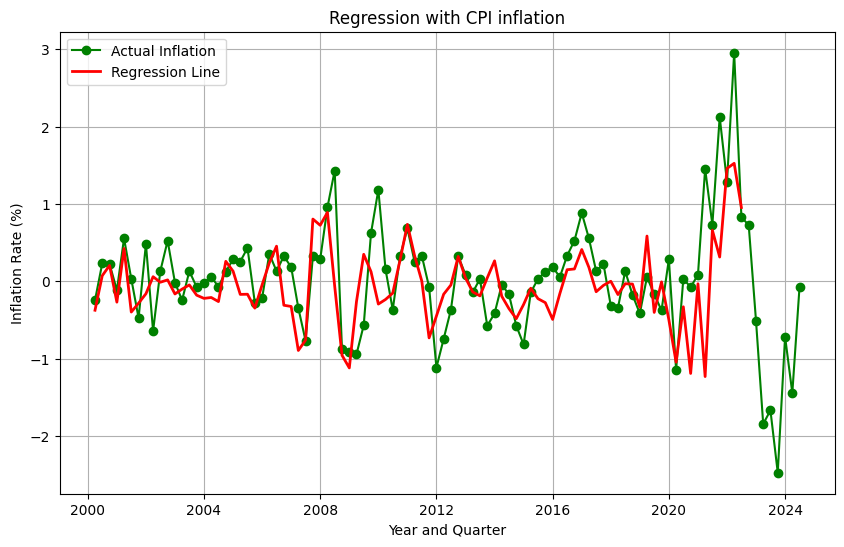

In [ ]:
data['Date'] = pd.to_datetime(data['YEAR'].astype(str) + ' ' + data['QUARTER'].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}), format='%Y %m')
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['INFLATION_diff'], label='Actual Inflation', color='green', marker='o')
plt.plot(data['Date'][:len(y_pred)], y_pred, label='Regression Line', color='red', linewidth=2)
plt.title('Regression with CPI inflation')
plt.xlabel('Year and Quarter')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()

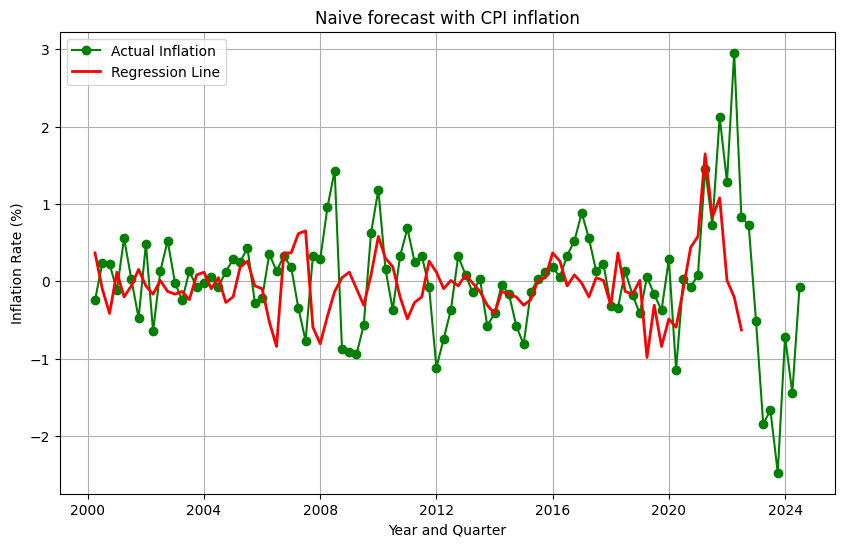

In [ ]:
data['Date'] = pd.to_datetime(data['YEAR'].astype(str) + ' ' + data['QUARTER'].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}), format='%Y %m')
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['INFLATION_diff'], label='Actual Inflation', color='green', marker='o')
plt.plot(data['Date'][:len(y_pred2)], y_pred2, label='Regression Line', color='red', linewidth=2)
plt.title('Naive forecast with CPI inflation')
plt.xlabel('Year and Quarter')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()

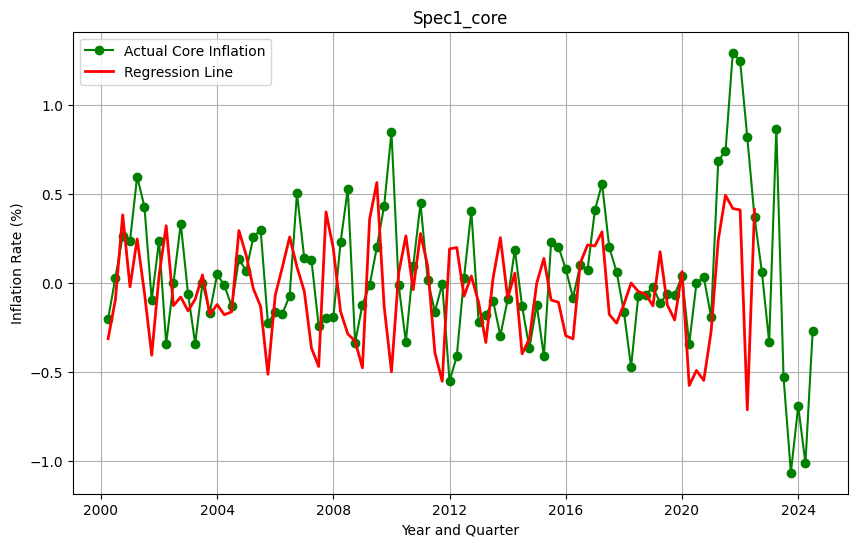

In [ ]:
data['Date'] = pd.to_datetime(data['YEAR'].astype(str) + ' ' + data['QUARTER'].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}), format='%Y %m')
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['CORE_INFLATION_diff'], label='Actual Core Inflation', color='green', marker='o')
plt.plot(data['Date'][:len(y_pred3)], y_pred3, label='Regression Line', color='red', linewidth=2)
plt.title('Spec1_core')
plt.xlabel('Year and Quarter')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()

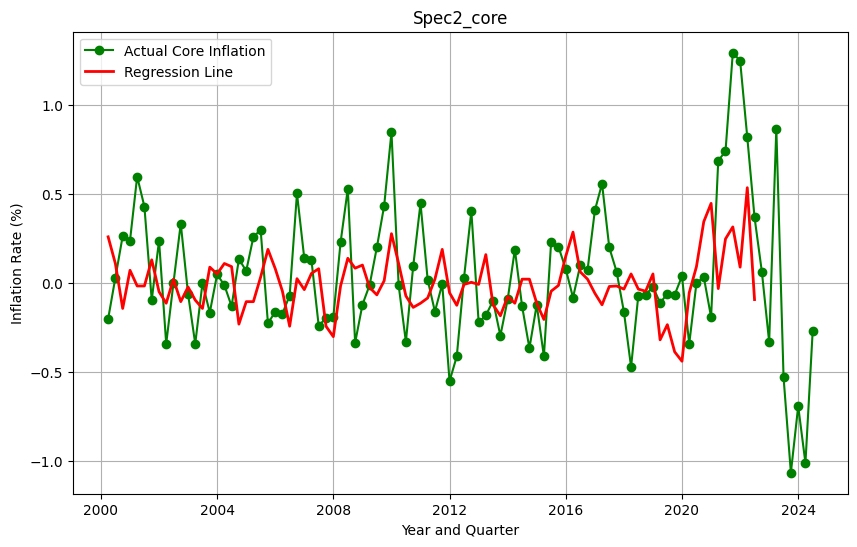

In [ ]:
data['Date'] = pd.to_datetime(data['YEAR'].astype(str) + ' ' + data['QUARTER'].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}), format='%Y %m')
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['CORE_INFLATION_diff'], label='Actual Core Inflation', color='green', marker='o')
plt.plot(data['Date'][:len(y_pred4)], y_pred4, label='Regression Line', color='red', linewidth=2)
plt.title('Spec2_core')
plt.xlabel('Year and Quarter')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()

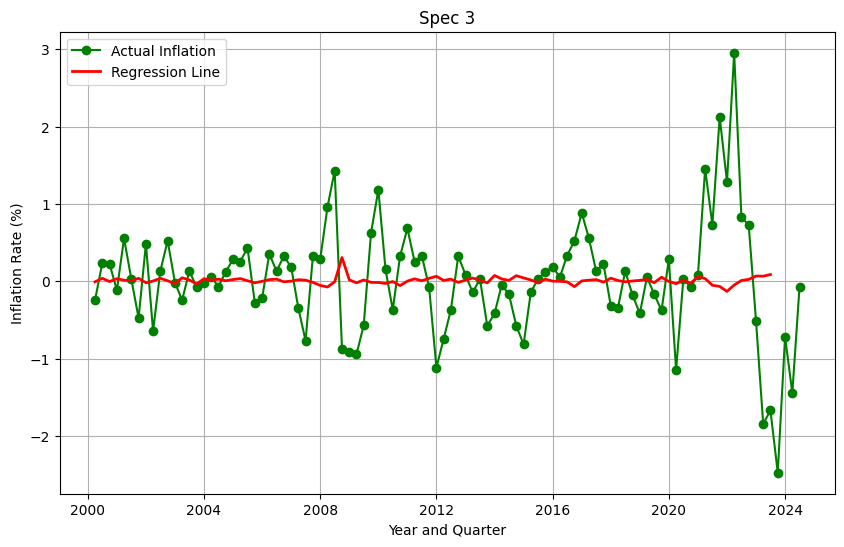

In [ ]:
data['Date'] = pd.to_datetime(data['YEAR'].astype(str) + ' ' + data['QUARTER'].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}), format='%Y %m')
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['INFLATION_diff'], label='Actual Inflation', color='green', marker='o')
plt.plot(data['Date'][:len(y_pred5)], y_pred5, label='Regression Line', color='red', linewidth=2)
plt.title('Spec 3')
plt.xlabel('Year and Quarter')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()

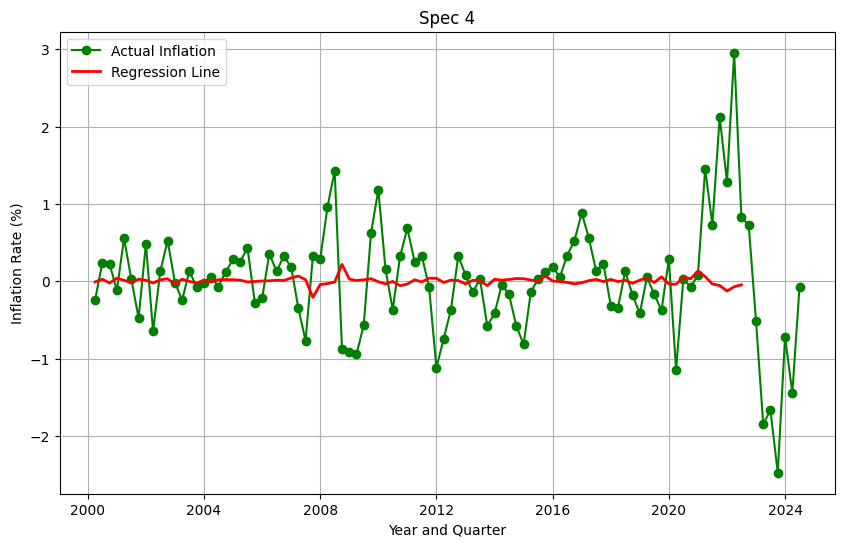

In [ ]:
data['Date'] = pd.to_datetime(data['YEAR'].astype(str) + ' ' + data['QUARTER'].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}), format='%Y %m')
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['INFLATION_diff'], label='Actual Inflation', color='green', marker='o')
plt.plot(data['Date'][:len(y_pred6)], y_pred6, label='Regression Line', color='red', linewidth=2)
plt.title('Spec 4')
plt.xlabel('Year and Quarter')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()

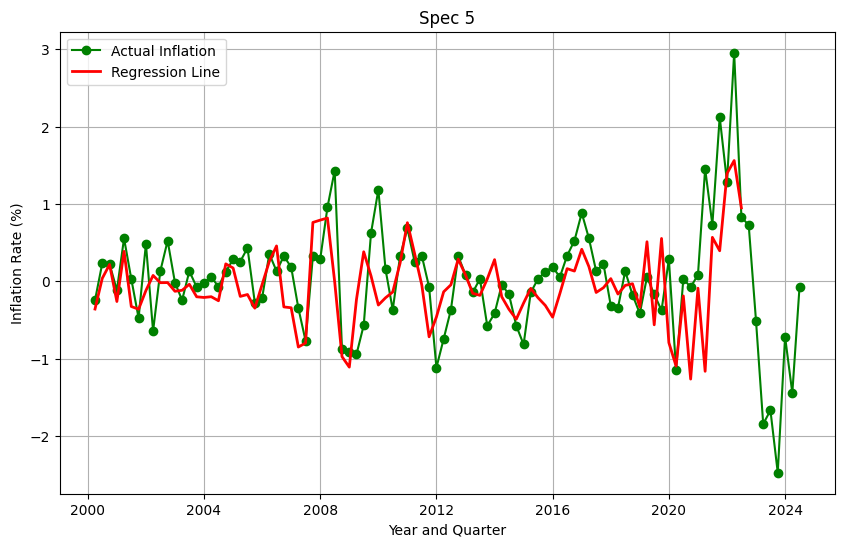

In [ ]:
data['Date'] = pd.to_datetime(data['YEAR'].astype(str) + ' ' + data['QUARTER'].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}), format='%Y %m')
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['INFLATION_diff'], label='Actual Inflation', color='green', marker='o')
plt.plot(data['Date'][:len(y_pred7)], y_pred7, label='Regression Line', color='red', linewidth=2)
plt.title('Spec 5')
plt.xlabel('Year and Quarter')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()

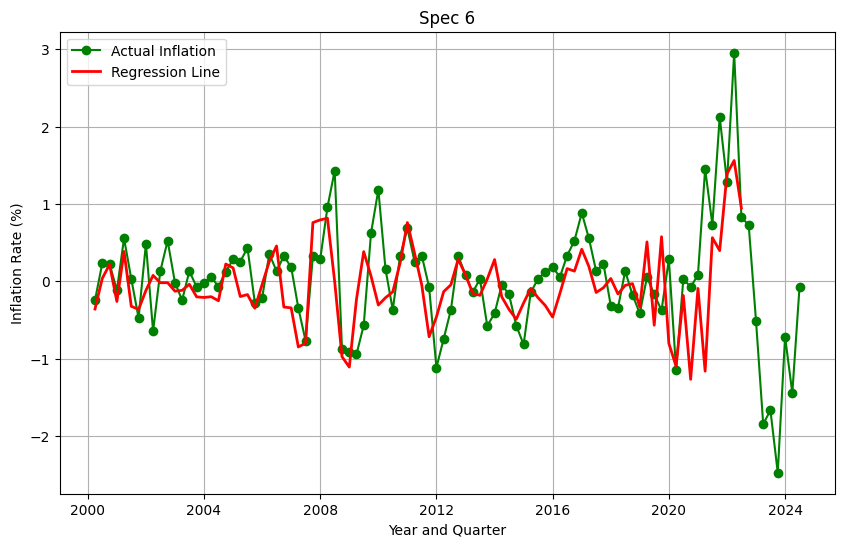

In [ ]:
data['Date'] = pd.to_datetime(data['YEAR'].astype(str) + ' ' + data['QUARTER'].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}), format='%Y %m')
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['INFLATION_diff'], label='Actual Inflation', color='green', marker='o')
plt.plot(data['Date'][:len(y_pred8)], y_pred8, label='Regression Line', color='red', linewidth=2)
plt.title('Spec 6')
plt.xlabel('Year and Quarter')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()

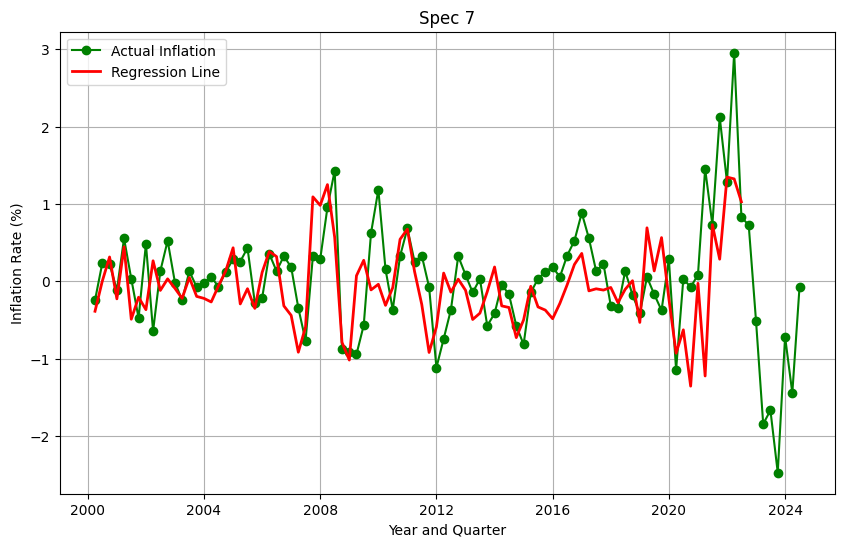

In [ ]:
data['Date'] = pd.to_datetime(data['YEAR'].astype(str) + ' ' + data['QUARTER'].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}), format='%Y %m')
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['INFLATION_diff'], label='Actual Inflation', color='green', marker='o')
plt.plot(data['Date'][:len(y_pred9)], y_pred9, label='Regression Line', color='red', linewidth=2)
plt.title('Spec 7')
plt.xlabel('Year and Quarter')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()